In [1]:
import torch
from torch.nn.utils.rnn import pad_sequence
from custom_types import CustomDataset
from dataset import get_train_dataset
from model import generate_caption
from model_run import get_encoder_decoder, get_optimizer, train_model
from utils import load_checkpoint, ensure_checkpoints_dir_exists, get_device
from inference import (
    get_image,
    preprocess_image_for_inference,
    get_dataset_image_and_captions,
    show_dataset_inference,
    show_image_inference,
)

/Users/vibhuagarwal/Library/Caches/pypoetry/virtualenvs/image-captioning-dl-MbwPk5w2-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vibhuagarwal/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
device = get_device()
print(f"Using device: {device}")

train_dataset = get_train_dataset()

Using device: mps


In [3]:
def collate_fn(
    batch: list[tuple[torch.Tensor, list[int]]],
) -> tuple[torch.Tensor, torch.Tensor]:
    batch.sort(key=lambda x: len(x[1]), reverse=True)
    images = torch.stack([item[0] for item in batch])
    all_captions = [torch.tensor(item[1], dtype=torch.long) for item in batch]
    captions = pad_sequence(all_captions, batch_first=True, padding_value=0)
    return images, captions


def get_train_loader() -> torch.utils.data.DataLoader:
    return torch.utils.data.DataLoader(
        train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
    )

In [4]:
encoder, decoder = get_encoder_decoder(train_dataset)
train_loader = get_train_loader()
optimizer = get_optimizer(encoder, decoder)

Loading vocabulary from cache: flickr8k_vocab_cache.pt


In [5]:
def infer_ds_img(
    train_dataset: CustomDataset,
    sample_index_in_hf_dataset: int,
):
    img_tensor = get_dataset_image_and_captions(
        train_dataset, sample_index_in_hf_dataset
    )[0]
    generated_caption = generate_caption(
        encoder,
        decoder,
        img_tensor,
        device,
        train_dataset.vocabularize_token,
        train_dataset.inverse_vocabularize_token,
    )
    show_dataset_inference(
        train_dataset,
        sample_index_in_hf_dataset,
        generated_caption,
    )


def infer_img(image_path: str):
    image_pil = get_image(image_path)
    image_tensor = preprocess_image_for_inference(image_pil, device)
    generated_caption = generate_caption(
        encoder,
        decoder,
        image_tensor,
        device,
        train_dataset.vocabularize_token,
        train_dataset.inverse_vocabularize_token,
    )
    show_image_inference(
        image_path,
        generated_caption,
    )

In [6]:
checkpoint_file = "saved_checkpoints/single_layer_rnn_greedy_search_ep44.pth.tar"
load_checkpoint(checkpoint_file, encoder, decoder, optimizer, device)

Loading checkpoint from 'saved_checkpoints/single_layer_rnn_greedy_search_ep44.pth.tar'...
Checkpoint epoch:44 successfully loaded.


44

In [8]:
sample_images = [
    "sample_images/birds_in_sky.jpg",
    "sample_images/beautiful_bird.jpg",
    "sample_images/computer_and_person.jpg",
    "sample_images/dog_kitten_small.jpeg",
    "sample_images/football_play_complex.jpg",
    "sample_images/horses_hd.jpeg",
    "sample_images/peacock_in_jungle.jpg",
    "sample_images/people_racing_side.jpg",
    "sample_images/real_madrid_celebrating_small.jpeg",
    "sample_images/ronaldo_kicking_football.jpg",
    "sample_images/ronaldo_messi_football.jpg",
    "sample_images/single_horse.jpeg",
]

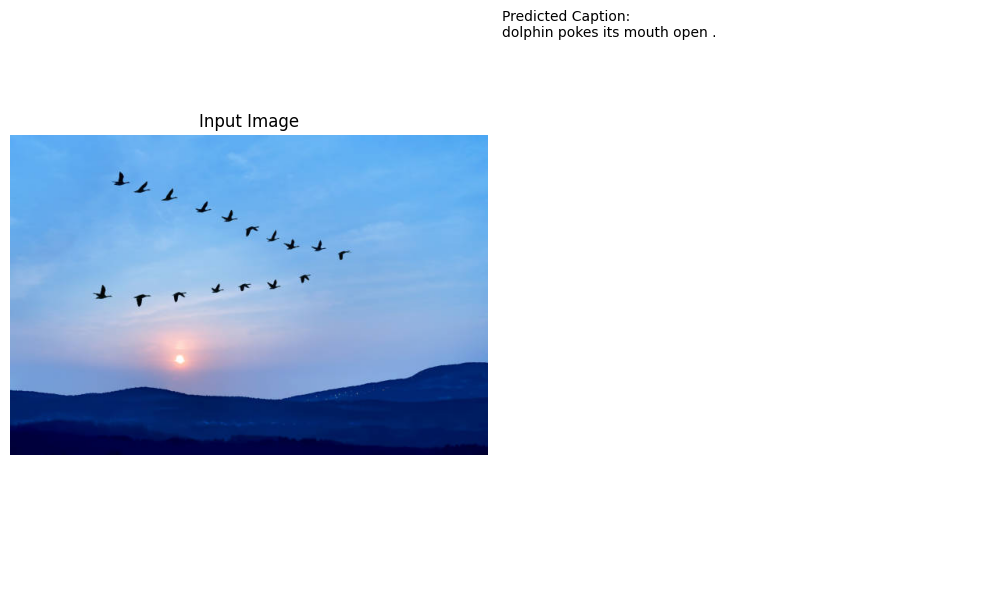

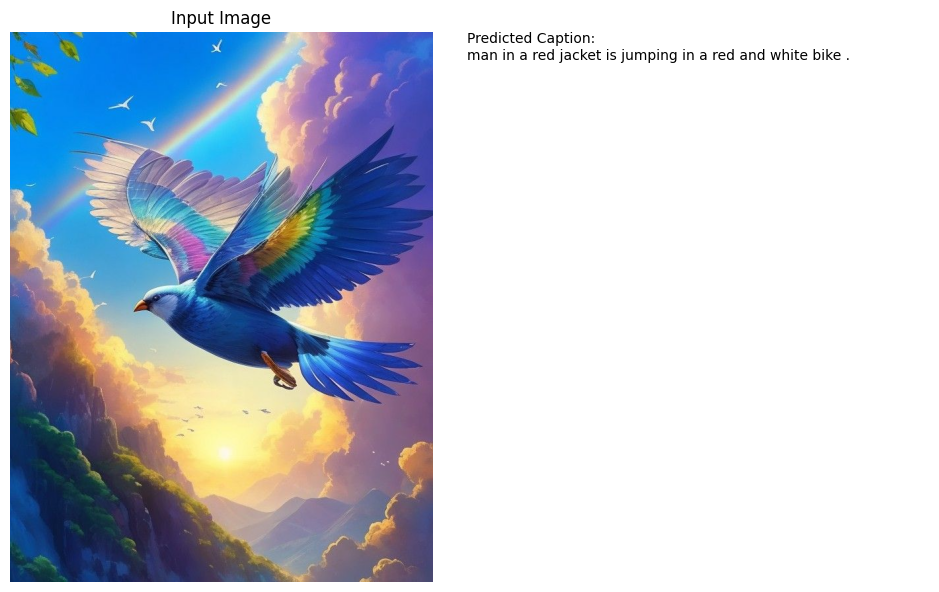

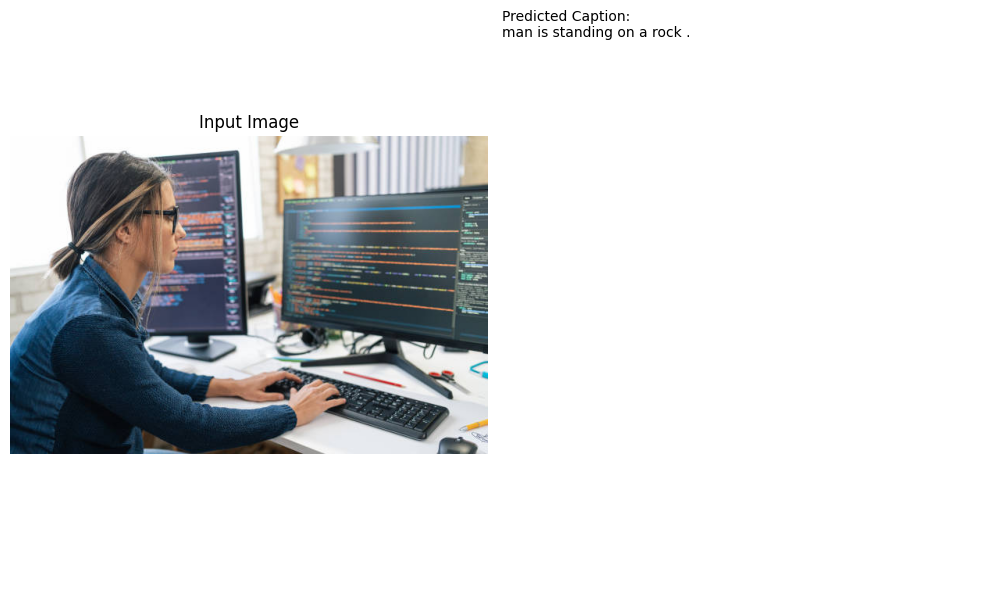

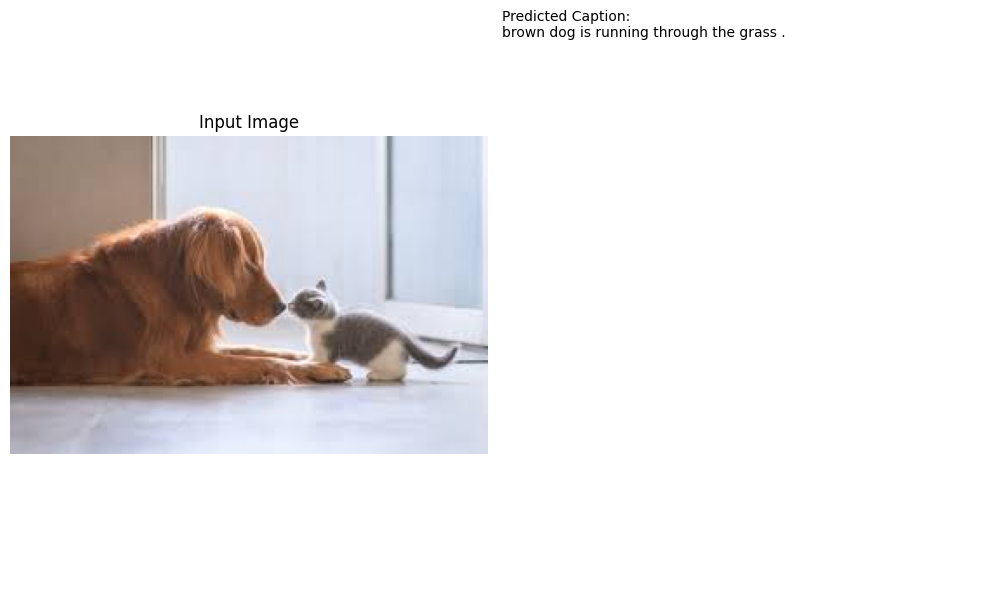

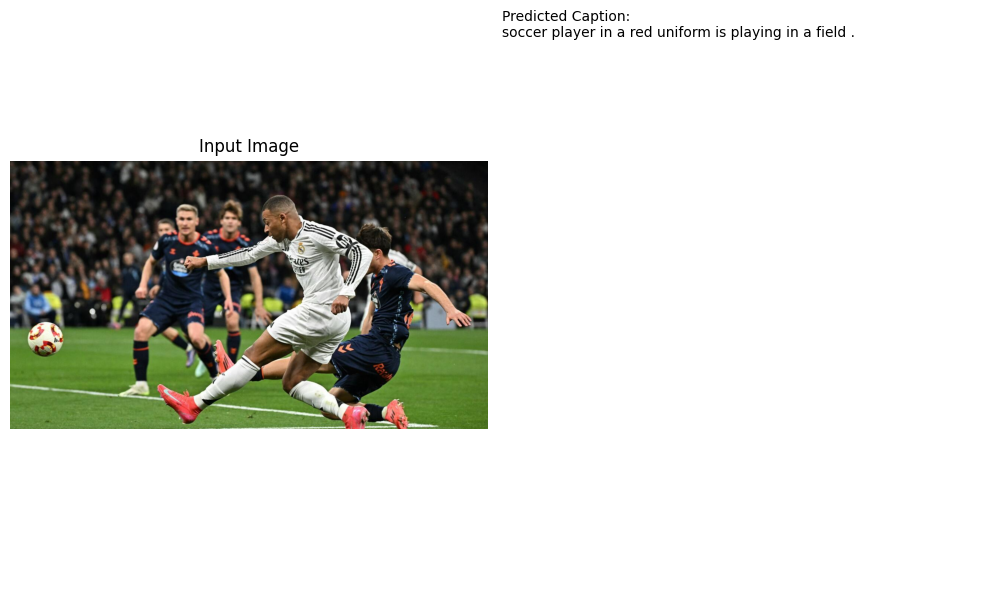

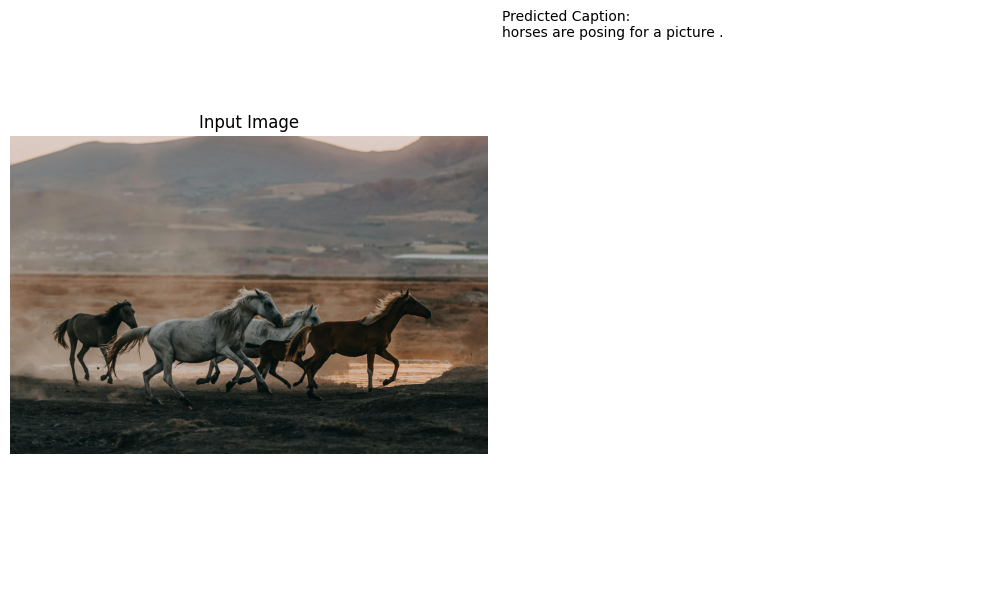

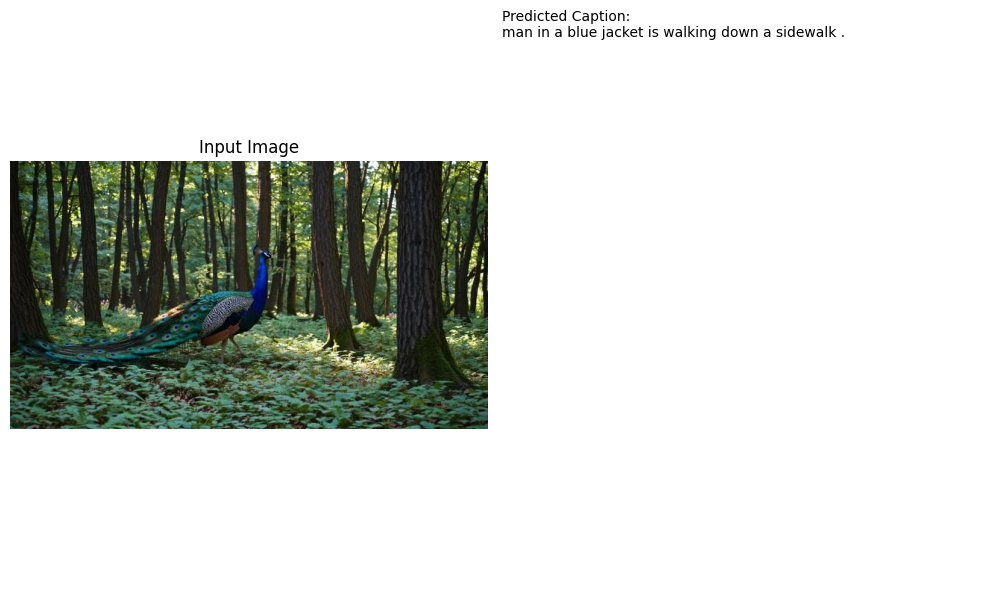

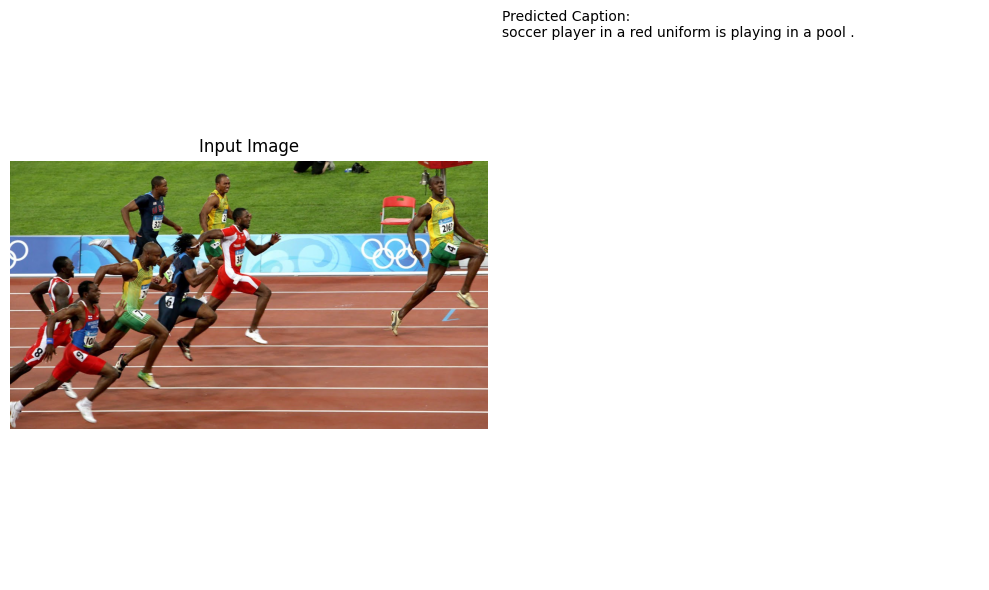

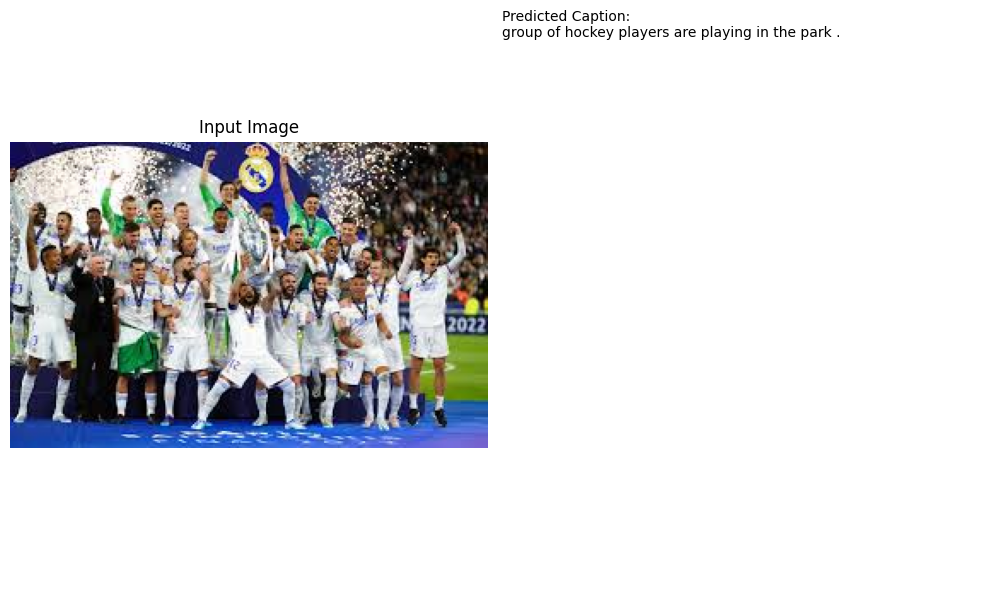

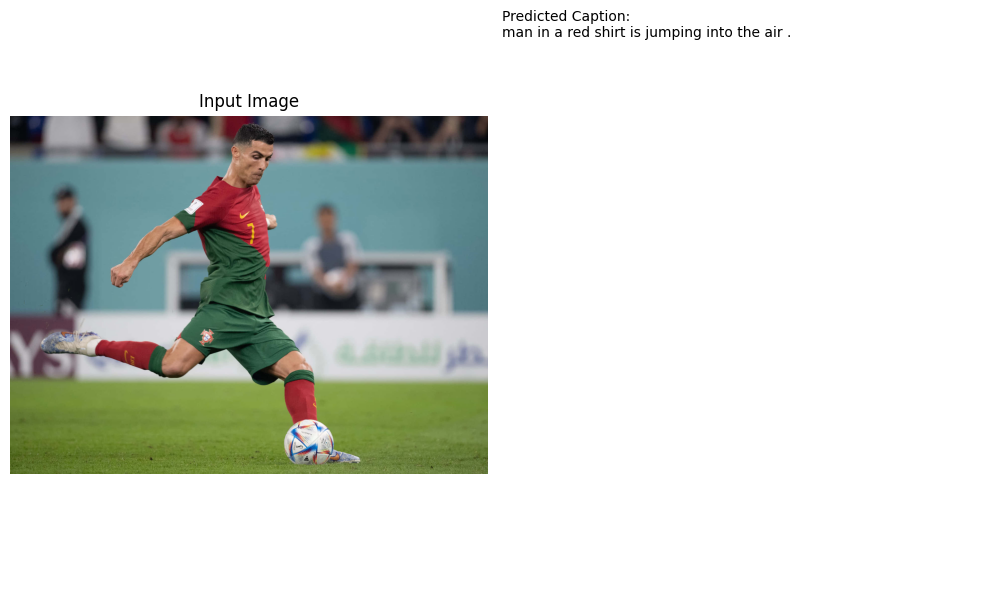

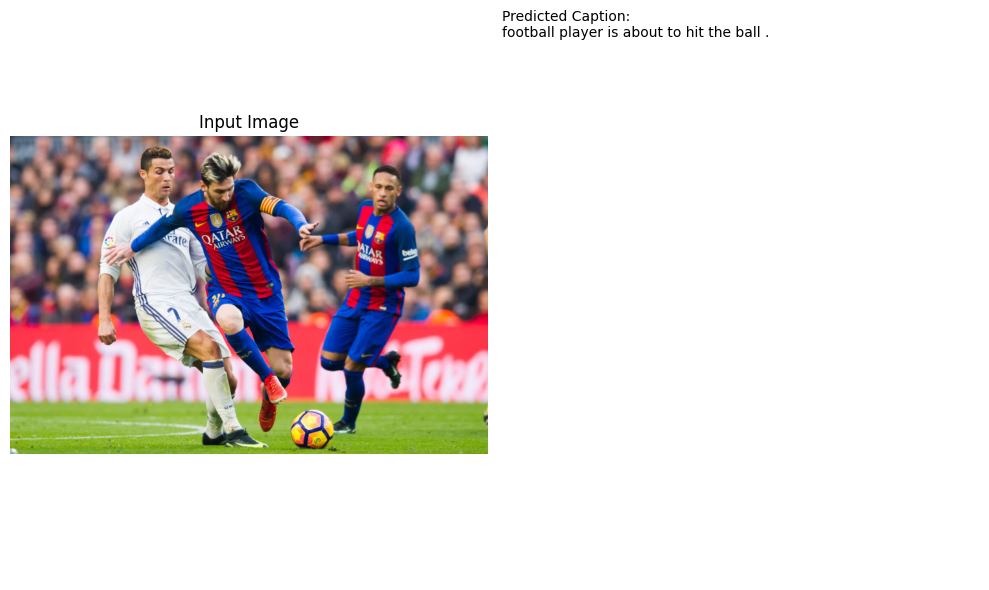

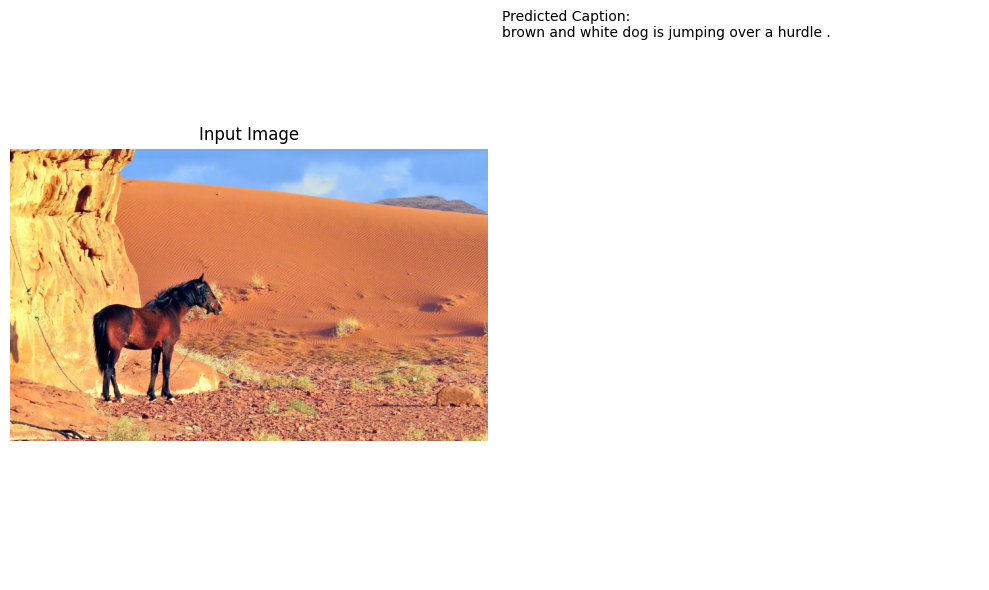

In [9]:
for img in sample_images:
    infer_img(img)